In [1]:
# Packages laden
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.backend import binary_crossentropy
from matplotlib import pyplot as plt
from math import sqrt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]

In [5]:
# Preprocessing der Rohdaten: 100%
ZR_100new=np.atleast_2d(ZR_100)
if ZR_100new.shape[0]==1:
    ZR_100new=ZR_100new.T
nb_samples_100, nb_series_100 = ZR_100new.shape

In [6]:
# Preprocessing der Rohdaten: 46%
ZR_46new=np.atleast_2d(ZR_46)
if ZR_46new.shape[0]==1:
    ZR_46new=ZR_46new.T
nb_samples_46, nb_series_46 = ZR_46new.shape

In [7]:
# Einteilung in Trainings- und Testdaten: nicht mehr ZR sondern X --> X_train etc
test_size_100=int(0.3*nb_samples_100)
train_100, test_100 = ZR_100[:-test_size_100], ZR_100[-test_size_100:] 

test_size_46=int(0.35*nb_samples_46)
train_46, test_46 = ZR_46[:-test_size_46], ZR_46[-test_size_46:]

In [8]:
# Shape des Input und Outputs anpassen: 100%
look_forward=60
window_size=12
# Trainingsdaten
Xtrain_100=np.atleast_3d(np.array([train_100[start:start+window_size] for start in range(0, train_100.shape[0]-(window_size+look_forward))]))
ytrain_100=train_100[window_size+look_forward:]
qtrain_100=np.atleast_3d([train_100[-(window_size):]])
print(qtrain_100.shape, ytrain_100.shape, Xtrain_100.shape)

# Testdaten
Xtest_100=np.atleast_3d(np.array([test_100[start:start+window_size] for start in range(0, test_100.shape[0]-(window_size+look_forward))]))
ytest_100=test_100[window_size+look_forward:]
qtest_100=np.atleast_3d([test_100[-(window_size):]])
print(qtest_100.shape, ytest_100.shape, Xtest_100.shape)

(1, 12, 1) (533,) (533, 12, 1)
(1, 12, 1) (186,) (186, 12, 1)


In [9]:
# Shape des Input und Outputs anpassen: 46%
# Trainingsdaten
Xtrain_46=np.atleast_3d(np.array([train_46[start:start+window_size] for start in range(0, train_46.shape[0]-(window_size+look_forward))]))
ytrain_46=train_46[window_size+look_forward:]
qtrain_46=np.atleast_3d([train_46[-(window_size):]])
print(qtrain_46.shape, ytrain_46.shape, Xtrain_46.shape)

# Testdaten
Xtest_46=np.atleast_3d(np.array([test_46[start:start+window_size] for start in range(0, test_46.shape[0]-(window_size+look_forward))]))
ytest_46=test_46[window_size+look_forward:]
qtest_46=np.atleast_3d([test_46[-(window_size):]])
print(qtest_46.shape, ytest_46.shape, Xtest_46.shape)

(1, 12, 1) (188,) (188, 12, 1)
(1, 12, 1) (68,) (68, 12, 1)


In [10]:
# Modell zusammenbauen: 
nb_filter_1=32
nb_filter_2=64
nb_filter_3=64
filter_length=2
nb_input_series=1
nb_outputs=1
model= Sequential()
model.add(Convolution1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='relu', 
                        input_shape=(window_size, nb_input_series)))
model.add(Convolution1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(nb_outputs, activation='linear')) 
model.compile(loss='mse', optimizer='adam', metrics=['mae']) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(12, 1), filters=32, kernel_size=2)`
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=2)`
  # This is added back by InteractiveShellApp.init_path()


In [11]:
# Modellzusammenfassung
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 32)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 321       
Total params: 4,577
Trainable params: 4,577
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Replizierbarkeit gewährleisten
np.random.seed(1)

In [73]:
# Modellanpassen: 100%
history_reg=model.fit(Xtrain_100, ytrain_100, epochs=200, batch_size=25, validation_data=(Xtest_100, ytest_100))

Train on 533 samples, validate on 186 samples
Epoch 1/200
533/533 [==============================] - 0s 259us/step - loss: 126461014.7842 - mean_absolute_error: 9140.5694 - val_loss: 72913903.9140 - val_mean_absolute_error: 6885.7883
Epoch 2/200
533/533 [==============================] - 0s 266us/step - loss: 125546058.9418 - mean_absolute_error: 9056.6513 - val_loss: 95574162.5699 - val_mean_absolute_error: 8145.6647
Epoch 3/200
533/533 [==============================] - 0s 323us/step - loss: 127745999.3246 - mean_absolute_error: 9183.3982 - val_loss: 66114537.0430 - val_mean_absolute_error: 6432.7390
Epoch 4/200
533/533 [==============================] - 0s 276us/step - loss: 125490959.5047 - mean_absolute_error: 9104.1135 - val_loss: 69640483.3978 - val_mean_absolute_error: 6741.3851
Epoch 5/200
533/533 [==============================] - 0s 257us/step - loss: 124589395.1820 - mean_absolute_error: 9017.9055 - val_loss: 82178703.9570 - val_mean_absolute_error: 7366.3963
Epoch 6/200
53

533/533 [==============================] - 0s 315us/step - loss: 125098198.9343 - mean_absolute_error: 9074.1577 - val_loss: 87282951.0108 - val_mean_absolute_error: 7686.2206
Epoch 88/200
533/533 [==============================] - 0s 276us/step - loss: 122710268.2326 - mean_absolute_error: 9059.8687 - val_loss: 67338753.7204 - val_mean_absolute_error: 6477.2140
Epoch 89/200
533/533 [==============================] - 0s 270us/step - loss: 128960754.1614 - mean_absolute_error: 9232.2548 - val_loss: 78652450.1613 - val_mean_absolute_error: 7232.7062
Epoch 90/200
533/533 [==============================] - 0s 261us/step - loss: 126174885.3283 - mean_absolute_error: 9107.2108 - val_loss: 93574136.7742 - val_mean_absolute_error: 8087.1865
Epoch 91/200
533/533 [==============================] - 0s 291us/step - loss: 126717894.4090 - mean_absolute_error: 9128.4102 - val_loss: 102906852.9032 - val_mean_absolute_error: 8457.7453
Epoch 92/200
533/533 [==============================] - 0s 281us/st

Epoch 130/200
533/533 [==============================] - 0s 317us/step - loss: 129660641.0657 - mean_absolute_error: 9299.5149 - val_loss: 99726586.2366 - val_mean_absolute_error: 8169.3076
Epoch 131/200
533/533 [==============================] - 0s 281us/step - loss: 124678044.8931 - mean_absolute_error: 9116.4081 - val_loss: 74317578.6452 - val_mean_absolute_error: 7032.4850
Epoch 132/200
533/533 [==============================] - 0s 261us/step - loss: 132607844.8480 - mean_absolute_error: 9386.2409 - val_loss: 111588279.7204 - val_mean_absolute_error: 8785.2816
Epoch 133/200
533/533 [==============================] - 0s 310us/step - loss: 124772585.6360 - mean_absolute_error: 9037.0939 - val_loss: 76061034.1183 - val_mean_absolute_error: 7141.8628
Epoch 134/200
533/533 [==============================] - 0s 263us/step - loss: 133659233.9662 - mean_absolute_error: 9412.6705 - val_loss: 63230953.0108 - val_mean_absolute_error: 6310.6248
Epoch 135/200
533/533 [==========================

Epoch 173/200
533/533 [==============================] - 0s 310us/step - loss: 124503840.8856 - mean_absolute_error: 9001.8411 - val_loss: 80060058.4624 - val_mean_absolute_error: 7258.8924
Epoch 174/200
533/533 [==============================] - 0s 283us/step - loss: 122647880.4953 - mean_absolute_error: 9016.7384 - val_loss: 91078208.5054 - val_mean_absolute_error: 7836.5452
Epoch 175/200
533/533 [==============================] - 0s 338us/step - loss: 121556753.2008 - mean_absolute_error: 8899.9542 - val_loss: 76184523.4086 - val_mean_absolute_error: 7195.2386
Epoch 176/200
533/533 [==============================] - 0s 332us/step - loss: 130922590.0863 - mean_absolute_error: 9252.8089 - val_loss: 62838954.2043 - val_mean_absolute_error: 6206.3650
Epoch 177/200
533/533 [==============================] - 0s 319us/step - loss: 128305968.9981 - mean_absolute_error: 9267.8331 - val_loss: 94040739.6774 - val_mean_absolute_error: 8032.1029
Epoch 178/200
533/533 [===========================

Text(0.5,1,'Loss Curves')

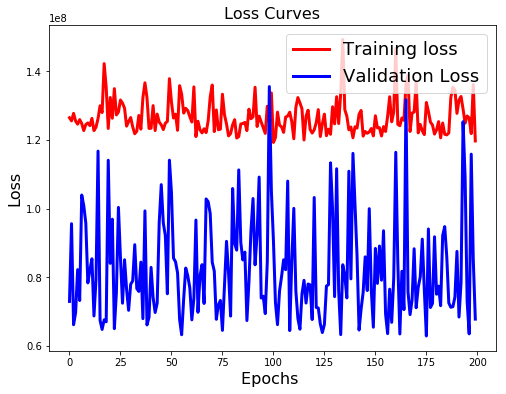

In [74]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

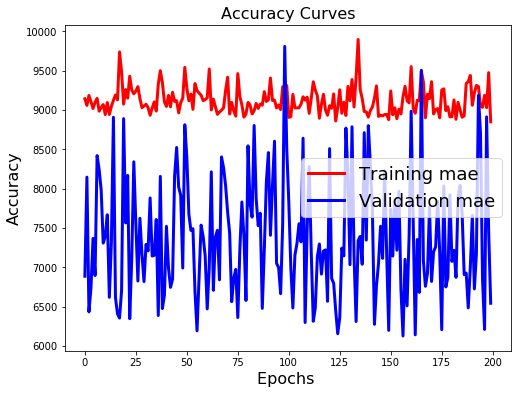

In [75]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [76]:
# Vorhersage generieren
predictions_100 = model.predict(Xtest_100)

predictions_train_100=model.predict(Xtrain_100)

In [77]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_100, predictions_100)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_100, predictions_train_100)
print('Train MSE: %.3f' % mse_train)

Test MSE: 67756873.487
Train MSE: 122994413.730


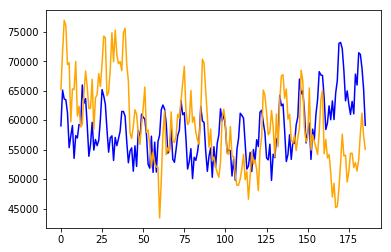

In [78]:
# Abtragen von Vorhersage und Testdaten
plt.plot(ytest_100, color='blue') 
plt.plot(predictions_100, color='orange') 
plt.show()

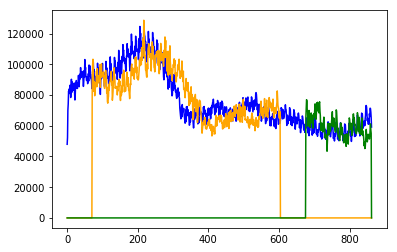

In [79]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_100)+(window_size+look_forward-1)] = predictions_train_100


# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(predictions_train_100)+2*(window_size+look_forward)-1:len(ZR_100)-1] = predictions_100
     
       
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [86]:
# Replizierbarkeit gewährleisten
np.random.seed(1)

In [87]:
# Modellanpassen: 46%
history_reg=model.fit(Xtrain_46, ytrain_46, epochs=200, batch_size=25, validation_data=(Xtest_46, ytest_46))

Train on 188 samples, validate on 68 samples
Epoch 1/200
188/188 [==============================] - 0s 309us/step - loss: 16328102.6170 - mean_absolute_error: 3331.0577 - val_loss: 88121708.0294 - val_mean_absolute_error: 7635.1575
Epoch 2/200
188/188 [==============================] - 0s 245us/step - loss: 15278260.0266 - mean_absolute_error: 3191.0984 - val_loss: 68190047.0368 - val_mean_absolute_error: 6563.2415
Epoch 3/200
188/188 [==============================] - 0s 298us/step - loss: 15332961.1117 - mean_absolute_error: 3188.5303 - val_loss: 107066679.6618 - val_mean_absolute_error: 8687.1612
Epoch 4/200
188/188 [==============================] - 0s 319us/step - loss: 13889123.5745 - mean_absolute_error: 3038.0503 - val_loss: 77409639.5956 - val_mean_absolute_error: 7063.1226
Epoch 5/200
188/188 [==============================] - 0s 410us/step - loss: 13904012.9973 - mean_absolute_error: 3052.0702 - val_loss: 99897691.2206 - val_mean_absolute_error: 8287.2883
Epoch 6/200
188/188

188/188 [==============================] - 0s 261us/step - loss: 12944929.2340 - mean_absolute_error: 2918.7301 - val_loss: 79560454.3603 - val_mean_absolute_error: 7191.1558
Epoch 88/200
188/188 [==============================] - 0s 277us/step - loss: 12563979.4628 - mean_absolute_error: 2892.3334 - val_loss: 86757823.5882 - val_mean_absolute_error: 7578.4178
Epoch 89/200
188/188 [==============================] - 0s 335us/step - loss: 12486439.9096 - mean_absolute_error: 2894.5586 - val_loss: 79091612.9191 - val_mean_absolute_error: 7144.1116
Epoch 90/200
188/188 [==============================] - 0s 319us/step - loss: 12576035.2394 - mean_absolute_error: 2929.5092 - val_loss: 89318972.4853 - val_mean_absolute_error: 7691.2774
Epoch 91/200
188/188 [==============================] - 0s 309us/step - loss: 12704397.2154 - mean_absolute_error: 2915.8864 - val_loss: 88733032.7059 - val_mean_absolute_error: 7703.5500
Epoch 92/200
188/188 [==============================] - 0s 282us/step - l

188/188 [==============================] - 0s 319us/step - loss: 11947867.0585 - mean_absolute_error: 2783.0186 - val_loss: 74955364.7206 - val_mean_absolute_error: 6965.2391
Epoch 174/200
188/188 [==============================] - 0s 377us/step - loss: 11503690.9309 - mean_absolute_error: 2726.6063 - val_loss: 85392370.3971 - val_mean_absolute_error: 7560.4986
Epoch 175/200
188/188 [==============================] - 0s 362us/step - loss: 11786723.8564 - mean_absolute_error: 2754.8288 - val_loss: 103055675.8235 - val_mean_absolute_error: 8499.1753
Epoch 176/200
188/188 [==============================] - 0s 351us/step - loss: 11847609.1090 - mean_absolute_error: 2827.5910 - val_loss: 92752476.4118 - val_mean_absolute_error: 7953.8850
Epoch 177/200
188/188 [==============================] - 0s 309us/step - loss: 11606786.7447 - mean_absolute_error: 2770.7320 - val_loss: 93195922.6912 - val_mean_absolute_error: 7956.7019
Epoch 178/200
188/188 [==============================] - 0s 404us/st

Text(0.5,1,'Loss Curves')

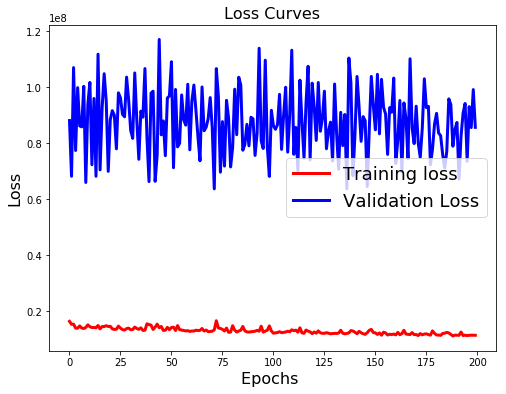

In [88]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

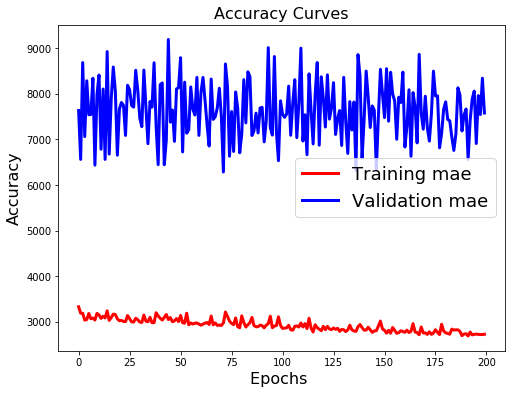

In [89]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [90]:
# Vorhersage generieren
predictions_46 = model.predict(Xtest_46)

predictions_train_46=model.predict(Xtrain_46)

In [91]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_46, predictions_46)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_46, predictions_train_46)
print('Train MSE: %.3f' % mse_train)

Test MSE: 85703631.544
Train MSE: 10948408.683


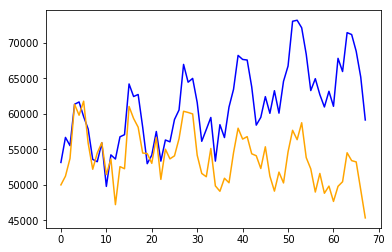

In [92]:
# Abtragen von Vorhersage und Testdaten
plt.plot(ytest_46, color='blue') 
plt.plot(predictions_46, color='orange')
plt.show()

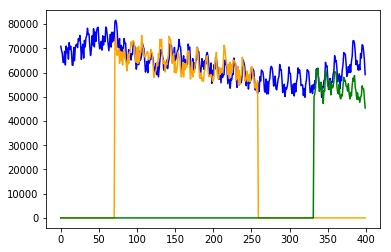

In [93]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_46)+(window_size+look_forward-1)] = predictions_train_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(predictions_train_46)+2*(window_size+look_forward):len(ZR)-1] = predictions_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()